In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [0]:
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

In [77]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


In [78]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


**Data Augmentation**

In [0]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # randomly flip and rotate
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

**Loading Images**

In [80]:
# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


**Checking Data**

In [81]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=(-10, 10), resample=False, expand=False)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [82]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=(-10, 10), resample=False, expand=False)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

**Training Indices**

In [0]:
# obtain training indices that will be used for validation
num_train = len(train_data)     # 50000
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

**Create sampler for training & validation**

In [0]:
# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

**Data Loaders**

In [0]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
validloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

**Image Classes**

In [0]:
# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

**Visualize a Batch of Training Data**

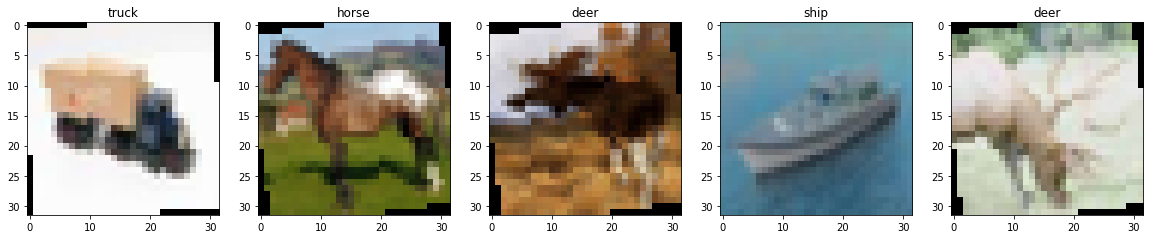

In [87]:
# Run this to test your data loader
sample_training_images, labels = next(iter(trainloader))
# print(sample_training_images.shape)        torch.Size([20, 3, 32, 32])
# print(labels.shape)                        torch.Size([20])
# print(labels)                              tensor([5, 8, 0, 1, 9, 7, 3, 6, 0, 1, 1, 4, 2, 2, 6, 1, 2, 7, 2, 4])

def plotImages(images_arr, labels):
  # print(images_arr.shape)      torch.Size([5, 3, 32, 32])
  fig, axes = plt.subplots(1, 5, figsize=(20,5))
  axes = axes.flatten()
  for img, ax, label in zip(images_arr, axes, labels):
    img = img / 2 + 0.5 
    img=img.permute(1,2,0)    # also we can use img=img.view(img.shape[1], img.shape[2], img.shape[0]). This is done to reshape from (C, H, W) to (H, W, C)
    # print(img.shape)        # torch.Size([32, 32, 3])
    ax.imshow(img)
    ax.set_title(classes[label])
  plt.show()
    
plotImages(sample_training_images[:5], labels[:5])        # Plot images 0-4

**Define the Network**

In [0]:
class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    # define the layers
    # Input channels = 3, output channels = 16, filter size = (3,3)
    # convolutional layer (sees 32x32x3 image tensor)
    self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
    # convolutional layer (sees 16x16x16 tensor)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
    # convolutional layer (sees 8x8x32 tensor)
    self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

    # max pooling layer
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    # linear layer (64*4*4 -> 500)
    self.linear1 = nn.Linear(64*4*4, 500)
    self.linear2 = nn.Linear(500, 10)

    # dropout layer (p=0.25)
    self.dropout = nn.Dropout(0.25)

  def forward(self, x):
    print(x.shape)
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))

    # flatten image input
    x = x.view(-1, 64*4*4) ## reshaping

    # add dropout layer
    x = self.dropout(x)

    # add 1st hidden layer, with relu activation function
    x = F.relu(self.linear1(x))

    # add dropout layer
    x = self.dropout(x)

    # add 2nd hidden layer, with relu activation function
    x = self.linear2(x)

    return x
    # Note: no final softmax!
    # just like Tensorflow, it's included in cross-entropy function

In [91]:
model = Model()
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

Model(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=1024, out_features=500, bias=True)
  (linear2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)
